## Import modules

In [1]:
import sys
sys.path.append('/home/malthera/Documents/IDDEFIX')

import numpy as np
import matplotlib.pyplot as plt
import iddefix
from scipy.constants import c as c_light


### Functions

In [19]:
def compute_fft(data_time, data_wake_potential):
    ds = (data_time[1] - data_time[0])* 1e-9 * c_light
    fmax = 3*1e9                                        # Maximum frequency to plot
    samples = 1001
    N = int((c_light/ds)//fmax*samples)
    Z = np.fft.fft(data_wake_potential, n=N)
    f = np.fft.fftfreq(len(Z), ds/c_light)

    # Mask invalid frequencies
    mask  = np.logical_and(f >= 0 , f < fmax)
    Z = Z[mask]*ds
    f = f[mask]                                         # Positive frequencies

    return f, Z

def timeframe_for_extrapolation(timedata, end_time):
    ds = np.mean(timedata[1:]-timedata[:-1])
    new_points = np.arange(timedata[-1], end_time, ds)
    return np.concatenate((timedata, new_points))*1e-9

# Simulation data example

This example features simulated wakefield data of the "SPS - transition" model.

The transition component in the SPS is included in the transverse impedance model for the SPS and is introduced to test the extrapolation capability of the evolutionary algorithm on a more elaborate problem. This case is particularly interesting as the impedance model only contains 16.66 ns of transverse wake potential data and is not fully decayed.

### Import data

In [3]:
# Importing wake potential data
data_wake_potential = np.loadtxt('data/004_SPS_model_transitions_q26.txt', comments='#', delimiter='\t')

# Extracting data
data_wake_time = data_wake_potential[:,0]
data_wake_dipolar = data_wake_potential[:,2]

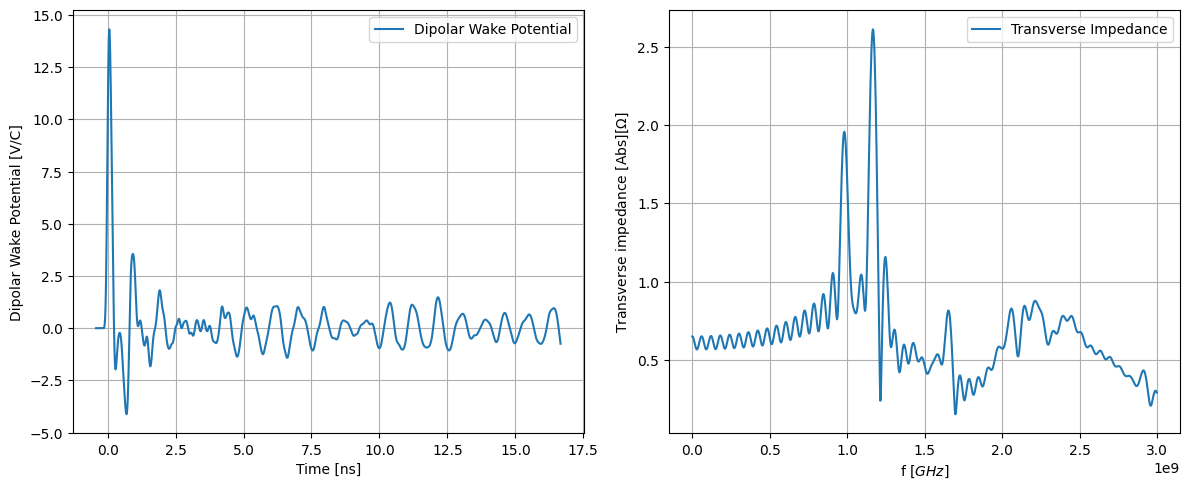

In [4]:
# Compute FFT to get Impedance
f, Z = compute_fft(data_wake_time, data_wake_dipolar)

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot data_wake_time vs data_wake_dipolar on the left
axs[0].plot(data_wake_time, data_wake_dipolar, label='Dipolar Wake Potential')
axs[0].set_xlabel('Time [ns]')
axs[0].set_ylabel('Dipolar Wake Potential [V/C]')
axs[0].grid(True)
axs[0].legend()

# Plot frequency vs impedance on the right
axs[1].plot(f, np.abs(Z), label='Transverse Impedance')
axs[1].set_xlabel('f $[GHz]$')
axs[1].set_ylabel('Transverse impedance [Abs]$[\Omega]$')
axs[1].grid(True)
axs[1].legend()


plt.tight_layout()
plt.show()

Extrapolating this impedance is tricky. This spectrum contains several coupled resonators, some with very broad resonator peaks and there seems to be a baseline as the impedance starts at 0.6 Ω. To investigate this ”baseline” a plot of impedances for different decay times is made:

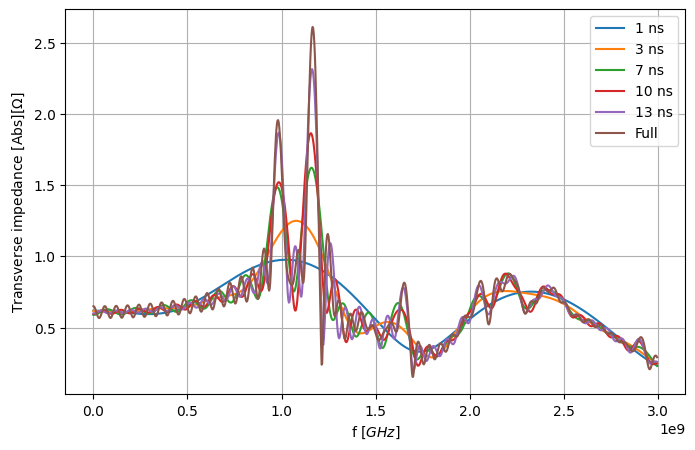

In [5]:
data_wake_dipolar_1 = data_wake_dipolar[data_wake_time <= 1]
data_wake_dipolar_3 = data_wake_dipolar[data_wake_time <= 3]
data_wake_dipolar_7 = data_wake_dipolar[data_wake_time <= 7]
data_wake_dipolar_10 = data_wake_dipolar[data_wake_time <= 10]
data_wake_dipolar_13 = data_wake_dipolar[data_wake_time <= 13]

_, Z_1 = compute_fft(data_wake_time, data_wake_dipolar_1)
_,Z_3 = compute_fft(data_wake_time, data_wake_dipolar_3)
_,Z_7 = compute_fft(data_wake_time, data_wake_dipolar_7)
_,Z_10 = compute_fft(data_wake_time, data_wake_dipolar_10)
_,Z_13 = compute_fft(data_wake_time, data_wake_dipolar_13)

plt.figure(figsize=(8, 5))
plt.plot(f, np.abs(Z_1), label='1 ns')
plt.plot(f, np.abs(Z_3), label='3 ns')
plt.plot(f, np.abs(Z_7), label='7 ns')
plt.plot(f, np.abs(Z_10), label='10 ns')
plt.plot(f, np.abs(Z_13), label='13 ns')
plt.plot(f, np.abs(Z), label='Full')
plt.xlabel('f $[GHz]$')
plt.ylabel('Transverse impedance [Abs]$[\Omega]$')
plt.grid(True)
plt.legend()

At 1 ns this baseline is well-established and strongly captured. Actually, the resonators develop and grow nicely from this blue curve. A decision is made to subtract this baseline and fit the resonators on the impedance data without the contribution from the first nanosecond of the model. The DE algorithm is run optimizing parameters for a total of 12 resonators on the baseline removed impedance data:

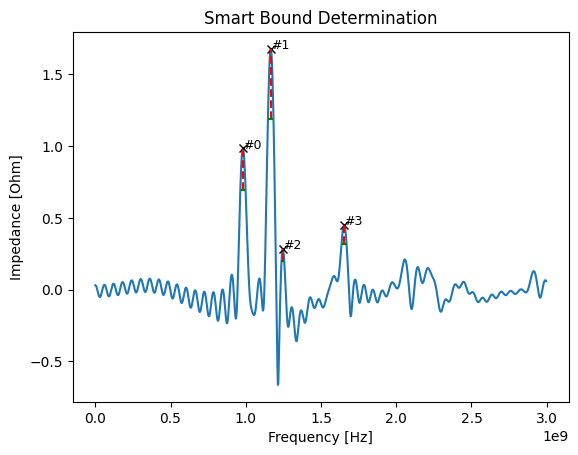

In [6]:
baseline_removed = iddefix.SmartBoundDetermination(f, np.abs(Z)-np.abs(Z_1), minimum_peak_height=0.25)
baseline_removed.inspect()
parameterBoundsBaselineRemoved = baseline_removed.find()

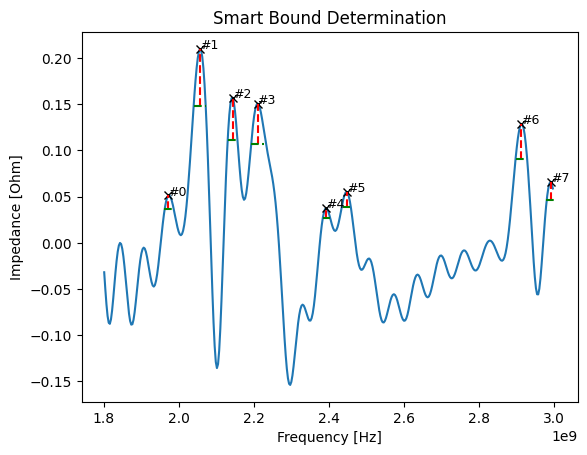

In [7]:
baseline_removed1 = iddefix.SmartBoundDetermination(f[f>1.8*1e9], np.abs(Z[f>1.8*1e9])-np.abs(Z_1[f>1.8*1e9]), minimum_peak_height=0.03)
baseline_removed1.inspect()
parameterBoundsBaselineRemoved1 = baseline_removed1.find()

In [8]:
#Number of resonators
Nres = 12 # can be changed to see what happens

wake_length = data_wake_time[-1]*1e-9*c_light
frequency = f #frequencies in Hz
impedance = np.abs(Z)-np.abs(Z_1) # Impedance with first ns removed



parameterBoundsBaselineRemoved = np.vstack((np.array(parameterBoundsBaselineRemoved), np.array(parameterBoundsBaselineRemoved1)))

#### Running IDDEFIX DE
Running the DE algorithm with IDDEFIX and chosen parameters.

"""supply the wake length to the resonator formula to use the 
partially decayed wake variant"""


In [9]:
%%time
DE_model = iddefix.EvolutionaryAlgorithm(frequency, 
                                         impedance,
                                         N_resonators=Nres, 
                                         parameterBounds=parameterBoundsBaselineRemoved,
                                         plane="transverse", 
                                         wake_length=wake_length,
                                         objectiveFunction=iddefix.ObjectiveFunctions.sumOfSquaredErrorReal)

DE_model.run_differential_evolution(maxiter=200,
                                    popsize=180,
                                    tol=0.001,
                                    mutation=(0.1, 0.5),
                                    crossover_rate=0.8)
print(DE_model.warning)

Optimization Progress: 100%|██████████| 200/200 [03:54<00:00,  1.17s/it]



----------------------------------------------------------------------
Resonator |   Rs [Ohm/m or Ohm]    |        Q         |    fres [Hz]     
----------------------------------------------------------------------
    1     |        1.70e+00        |      57.73       |    9.839e+08     
    2     |        3.16e+00        |      70.66       |    1.165e+09     
    3     |        8.05e-01        |      333.12      |    1.256e+09     
    4     |        7.55e-01        |      91.17       |    1.649e+09     
    5     |        2.16e-01        |      397.73      |    1.982e+09     
    6     |        8.37e-01        |      315.63      |    2.053e+09     
    7     |        4.53e-01        |      322.28      |    2.154e+09     
    8     |        3.29e-01        |      144.89      |    2.215e+09     
    9     |        1.82e-01        |      465.49      |    2.401e+09     
    10    |        2.46e-01        |      534.44      |    2.449e+09     
    11    |        2.56e-01        |      

In [16]:
DE_model.run_minimization_algorithm()

Method for minimization : Nelder-Mead


----------------------------------------------------------------------
Resonator |   Rs [Ohm/m or Ohm]    |        Q         |    fres [Hz]     
----------------------------------------------------------------------
    1     |        1.83e+00        |      62.17       |    9.838e+08     
    2     |        3.21e+00        |      72.42       |    1.165e+09     
    3     |        8.37e-01        |      361.89      |    1.257e+09     
    4     |        6.99e-01        |      83.56       |    1.650e+09     
    5     |        2.32e-01        |      358.28      |    1.991e+09     
    6     |        9.20e-01        |      342.65      |    2.052e+09     
    7     |        4.49e-01        |      290.12      |    2.155e+09     
    8     |        3.19e-01        |      153.86      |    2.216e+09     
    9     |        1.93e-01        |      461.55      |    2.400e+09     
    10    |        2.49e-01        |      502.84      |    2.452e+09     
    

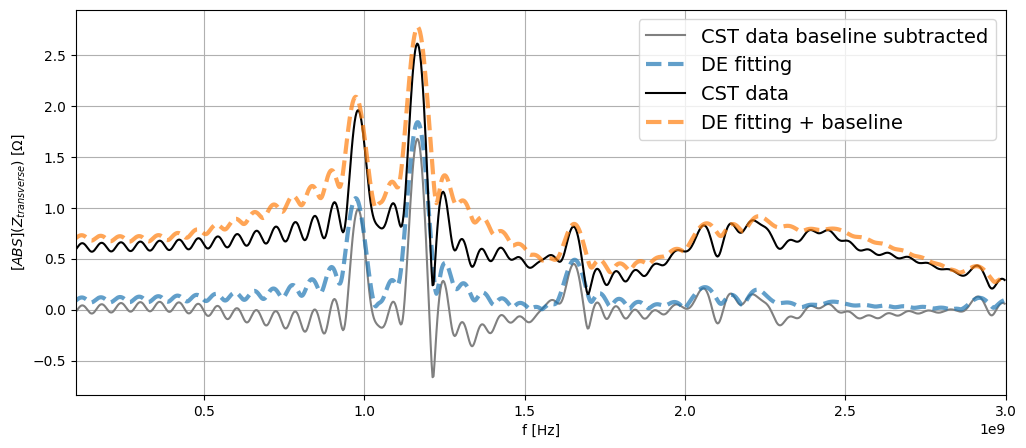

In [17]:
#Plot real part of impedance
fig, ax0 = plt.subplots(1, 1, figsize=(12,5))

ax0.plot(DE_model.frequency_data, DE_model.impedance_data, "grey", label='CST data baseline subtracted')

ax0.plot(DE_model.frequency_data, np.abs(DE_model.fitFunction(DE_model.frequency_data, dict(enumerate(DE_model.evolutionParameters.reshape(-1, 3))))),
         lw = 3, linestyle='--', label='DE fitting', alpha=0.7)

ax0.plot(DE_model.frequency_data, np.abs(Z), "black", label='CST data')

ax0.plot(DE_model.frequency_data, np.abs(Z_1)+np.abs(DE_model.fitFunction(DE_model.frequency_data, dict(enumerate(DE_model.minimizationParameters.reshape(-1, 3))))),
         lw = 3, linestyle='--', label='DE fitting + baseline', alpha=0.7)

#ax0.plot(DE_model.frequency_data, np.abs(Z_3)+np.abs(DE_model.fitFunction(DE_model.frequency_data, dict(enumerate(DE_model.minimizationParameters.reshape(-1, 3))))),
         #lw = 3, linestyle='--', label='GA_min+baseline', alpha=0.7)

ax0.set_xlabel('f [Hz]')
ax0.set_ylabel('$[ABS](Z_{transverse})$ [$\Omega$]')
ax0.legend(loc='best', fontsize=14)

ax0.set_xlim(0.1e9, 3e9)

ax0.grid()



plt.savefig("SPS_res_fitting_transverse.pdf", bbox_inches='tight')

The impedance model is to be extrapolated until 50 ns, thus the extrapolation is done for 50 ns, but any arbitrary time could have been chosen. The baseline is added to the extrapolation result.

In [24]:
new_timeframe = timeframe_for_extrapolation(data_wake_time, 50)

wake_extrapolated = iddefix.Wakes.n_Resonator_transverse_wake(new_timeframe, dict(enumerate(DE_model.minimizationParameters.reshape(-1, 3))))/c_light

data_wake_dipolar_1_padded = np.pad(data_wake_dipolar_1, (0, len(wake_extrapolated)-len(data_wake_dipolar_1)), 'constant')

### Wake potential vs. extrapolated wake function

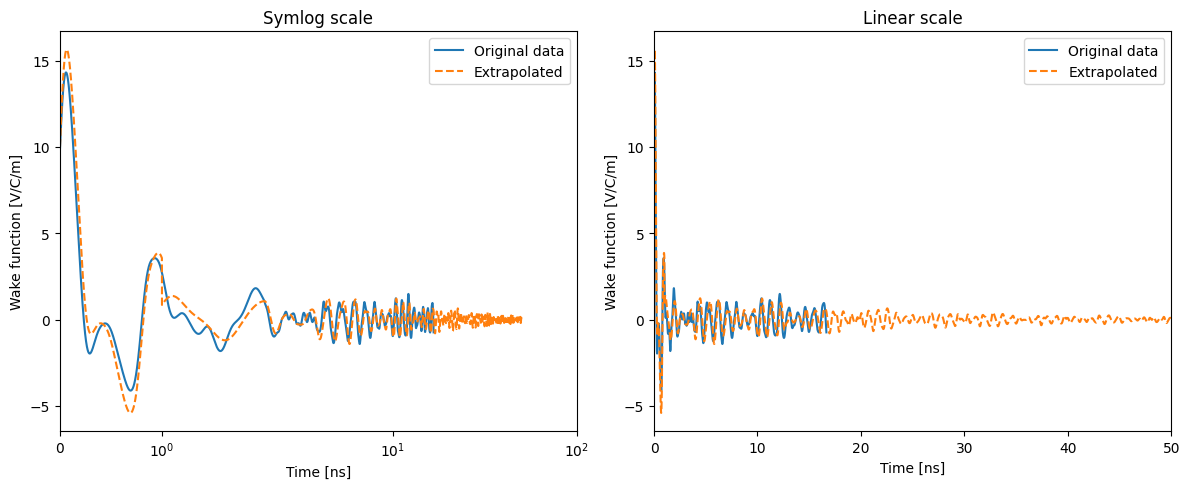

In [37]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot with symlog scale on the left
axs[0].plot(data_wake_time, data_wake_dipolar, label='Original data')
axs[0].plot(new_timeframe*1e9, wake_extrapolated+data_wake_dipolar_1_padded, label='Extrapolated', linestyle='--')
axs[0].set_xlabel('Time [ns]')
axs[0].set_ylabel('Wake function [V/C/m]')
axs[0].set_xscale('symlog')
axs[0].set_xlim(0, 100)
axs[0].title.set_text('Symlog scale')
axs[0].legend()

# Plot with linear scale until xlim(0,50) on the right
axs[1].plot(data_wake_time, data_wake_dipolar, label='Original data')
axs[1].plot(new_timeframe*1e9, wake_extrapolated+data_wake_dipolar_1_padded, label='Extrapolated', linestyle='--')
axs[1].set_xlabel('Time [ns]')
axs[1].set_ylabel('Wake function [V/C/m]')
axs[1].set_xlim(0, 50)
axs[1].title.set_text('Linear scale')
axs[1].legend()

plt.tight_layout()
plt.show()

### Impedance extrapolated

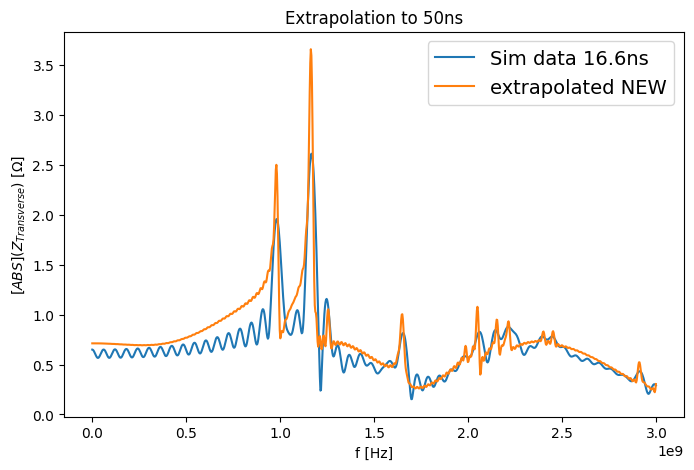

In [ ]:
f_50ns,Z_50ns = compute_fft(new_timeframe*1e9, wake_extrapolated+data_wake_dipolar_1_padded)

plt.figure(figsize=(8, 5))
plt.plot(f, np.abs(Z), label='Sim data 16.6ns')
plt.plot(f_50ns, np.abs(Z_50ns), label='Extrapolated to 50ns')
plt.legend()
plt.title('Extrapolation to 50ns')
plt.xlabel('f [Hz]')
plt.ylabel('$[ABS](Z_{Transverse})$ [$\Omega$]')
plt.legend(loc='best', fontsize=14)

ax0.set_xlim(0.1e9, 3e9)

ax0.grid()